In [1]:
from glotaran_tools.specification_parser import parse_yml
from glotaran_core.model import Dataset
from glotaran_models.kinetic import KineticSeperableModel
import numpy as np
from lmfit import Parameters
# Imports for plotting

import matplotlib.pyplot as plt
%matplotlib notebook

fitspec = '''
type: kinetic

parameter: {}

compartments: [s1, s2, s3]

megacomplexes:
    - label: mc1
      k_matrices: [k1]

k_matrices:
  - label: "k1"
    matrix: {{
      '("s1","s1")': 1,
      '("s2","s2")': 2,
      '("s3","s3")': 3,
}}

initial_concentrations: []

irf:
  - label: irf1
    type: gaussian
    center: 4
    width: 5

datasets: 
  - label: dataset1
    type: spectral
    megacomplexes: [mc1]
    path: none
    irf: irf1

'''
   

In [20]:
test_parameter = [101e-4, 202e-5, 505e-6, 0.1, 4]
test_amps = [7, 3, 30]
test_x = np.arange(12820, 15120, 4.6)
t0 = np.asarray(np.logspace(-100, 10))
times = np.concatenate([np.arange(-10, 1, 0.1).flatten(),
                        np.arange(-1, 1, 0.01).flatten(),
                       np.arange(10, 50, 1.5).flatten(),
                       np.arange(100, 1000, 15).flatten()])
print(times.shape)


simparams = Parameters()
simparams.add("p1", 101e-3)
simparams.add("p2",202e-4)
simparams.add("p3",505e-5)
simparams.add("p4",0.1)
simparams.add("p5",3.0)
simparams.pretty_print()
print(t0)

(397,)
Name     Value      Min      Max   Stderr     Vary     Expr
p1     0.101     -inf      inf     None     True     None
p2    0.0202     -inf      inf     None     True     None
p3   0.00505     -inf      inf     None     True     None
p4       0.1     -inf      inf     None     True     None
p5         3     -inf      inf     None     True     None
[  1.00000000e-100   1.75751062e-098   3.08884360e-096   5.42867544e-094
   9.54095476e-092   1.67683294e-089   2.94705170e-087   5.17947468e-085
   9.10298178e-083   1.59985872e-080   2.81176870e-078   4.94171336e-076
   8.68511374e-074   1.52641797e-071   2.68269580e-069   4.71486636e-067
   8.28642773e-065   1.45634848e-062   2.55954792e-060   4.49843267e-058
   7.90604321e-056   1.38949549e-053   2.44205309e-051   4.29193426e-049
   7.54312006e-047   1.32571137e-044   2.32995181e-042   4.09491506e-040
   7.19685673e-038   1.26485522e-035   2.22299648e-033   3.90693994e-031
   6.86648845e-029   1.20679264e-026   2.12095089e-024   3.

In [21]:
model = parse_yml(fitspec.format(test_parameter))
print(model)

Modeltype: Kinetic

Parameter
---------

Index: 1 Initial Value: 0.0101 Label: None
Index: 2 Initial Value: 0.00202 Label: None
Index: 3 Initial Value: 0.000505 Label: None
Index: 4 Initial Value: 0.1 Label: None
Index: 5 Initial Value: 4.0 Label: None

Megacomplexes
-------------

Label: mc1
K-Matrices: ['k1']

Datasets
--------

Dataset 'dataset1'

	Dataset Scaling: None
	Initial Concentration: None
	Megacomplexes: ['mc1']

	Irf: irf1


K-Matrices
----------

Label: k1
Matrix:
[[2 0 0]
 [0 3 0]
 [0 0 1]]


IRFs
----

Label: irf1 Type: 'Gaussian' Center: [4] Width: [5] Center Dispersion: [] Width Dispersion [] Scale: [], Nomalize: True



In [22]:
fitmodel = KineticSeperableModel(model)

(397, 501)
em
(501, 3)
[1, 2, 0]
-0.0225824648786
(501,)


<IPython.core.display.Javascript object>


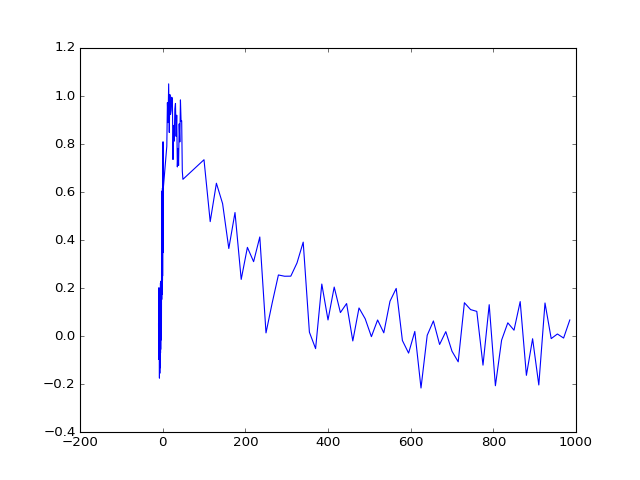

<IPython.core.display.Javascript object>


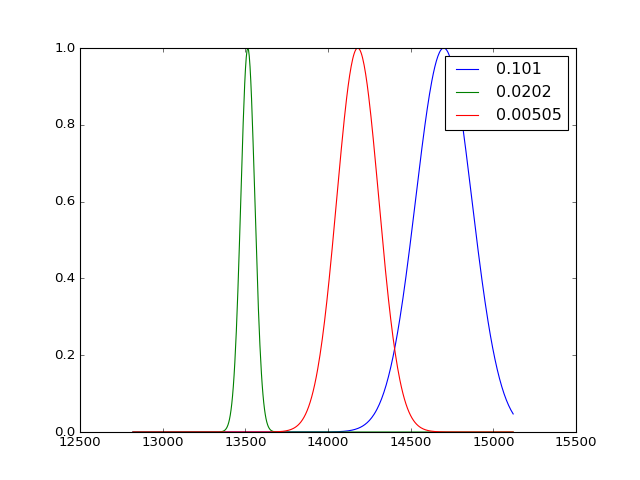

In [25]:
data = fitmodel.eval(simparams, *times, **{'dataset':'dataset1', 
                                           'noise':True, 'noise_std_dev':0.1,
                                           'dataset1_x': test_x,
                                           'amplitudes':[1, 1, 1],
                                          'locations':[14700, 13515, 14180],
                                           'delta': [400,100,300]
                                           })
# DAS
DAS = fitmodel.coefficients(**{'dataset':'dataset1','dataset1_x': test_x,
                                           'amplitudes':[1, 1, 1],
                                          'locations':[14700, 13515, 14180],
                                           'delta': [400,100,300]
                                           })
print(data[0,0])
print(test_x.shape)

fig = plt.figure()
plt.plot(times, data[:, 300])

fig = plt.figure()
d1, = plt.plot(test_x, DAS[:, 0], label=simparams['p1'].value)
d2, = plt.plot(test_x, DAS[:, 1], label=simparams['p2'].value)
d3, = plt.plot(test_x, DAS[:, 2], label=simparams['p3'].value)
plt.legend(handles=[d1, d2, d3])

<IPython.core.display.Javascript object>


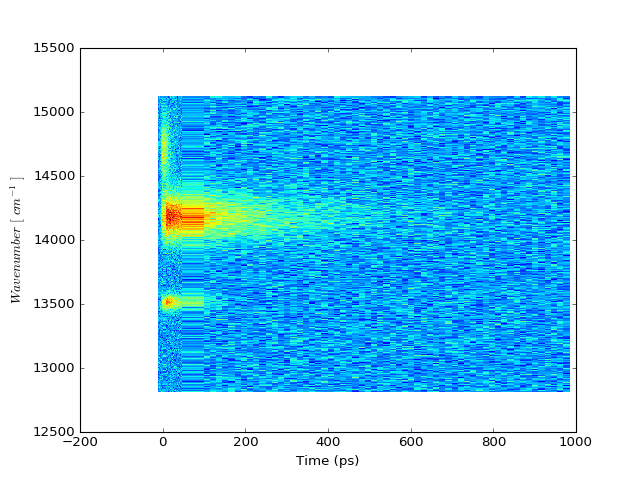

In [27]:
# Plot full trace

fig = plt.figure()
plt.xlabel('Time (ps)')
plt.ylabel('$Wavenumber\ [\ cm^{-1}\ ]$')
plt.pcolormesh(times, test_x, data.T)
plt.show()

In [26]:
%time{fitmodel.fit(fitmodel.get_initial_fitting_parameter(), *times, **{"dataset1": data})}
result = fitmodel.fit(fitmodel.get_initial_fitting_parameter(), *times, **{"dataset1": data})
result.best_fit_parameter.pretty_print()
reconstructed_data = result.eval(*times, **{"dataset1": data})


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1371e+03                                    9.30e+03    
       1              2         1.0192e+03      1.18e+02       2.00e+00       2.51e+03    
       2              6         1.0090e+03      1.03e+01       6.92e-03       1.23e+03    
       3              7         1.0007e+03      8.24e+00       1.38e-02       2.65e+03    
       4              8         9.9552e+02      5.20e+00       2.77e-02       1.29e+03    
       5              9         9.9413e+02      1.39e+00       5.54e-02       4.53e+02    
       6             10         9.9338e+02      7.51e-01       1.11e-01       1.28e+02    
       7             11         9.9233e+02      1.05e+00       2.21e-01       5.74e+01    
       8             12         9.9105e+02      1.28e+00       4.43e-01       7.50e+01    
       9             13         9.9059e+02      4.56e-01       4.68e-01       1.03e+02    

<IPython.core.display.Javascript object>


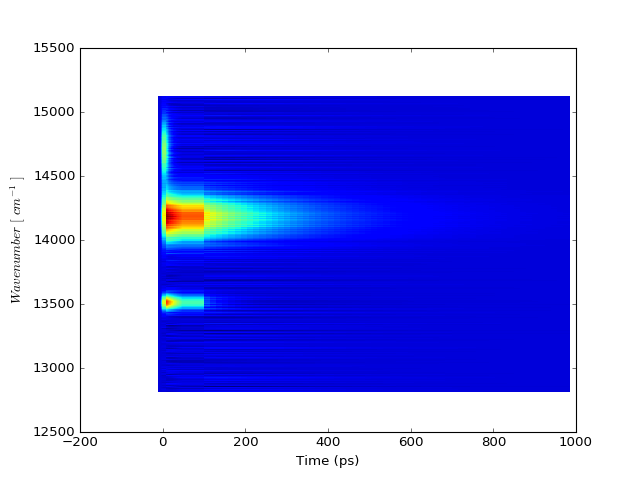

In [28]:
# Plot full trace

fig = plt.figure()
plt.xlabel('Time (ps)')
plt.ylabel('$Wavenumber\ [\ cm^{-1}\ ]$')
plt.pcolormesh(times, test_x, reconstructed_data.T)
plt.show()

(3, 501)


<IPython.core.display.Javascript object>


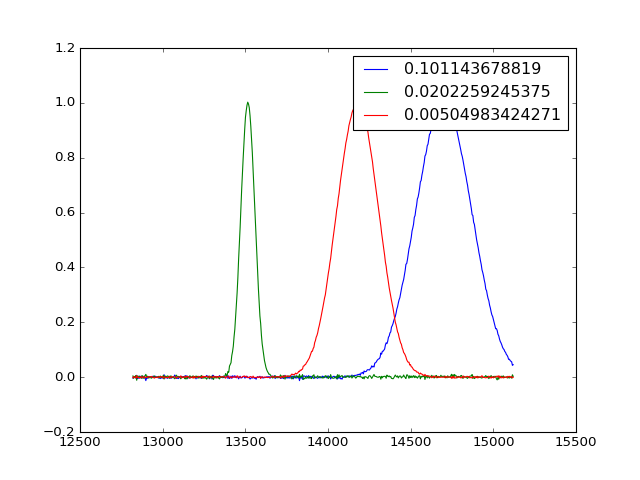

In [9]:
# DAS
DAS = result.coefficients(*times, **{'dataset':'dataset1', "dataset1": data})
print(DAS.shape)
fig = plt.figure()
d1, = plt.plot(test_x, DAS[0, :], label=result.best_fit_parameter['p1'].value)
d2, = plt.plot(test_x, DAS[1, :], label=result.best_fit_parameter['p2'].value)
d3, = plt.plot(test_x, DAS[2, :], label=result.best_fit_parameter['p3'].value)
plt.legend(handles=[d1, d2, d3])



In [10]:
data.shape

(2660, 501)